## Laboratorio 2 - Luis Epifanio

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from bs4 import BeautifulSoup

from nltk.tokenize import WordPunctTokenizer

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import seaborn as sns

import string
from time import time
import re

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/home/luis/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
from utils import load_datasets_unlabeled_test
train, dev, test = load_datasets_unlabeled_test()
X_train, y_train = train
X_dev, y_dev = dev
#X_test, y_test = test

In [4]:
print( 'Train      dataset has {} elements and resolution of {:.2f}%'.format( len(X_train) , ( 1 / len(X_train) ) * 100 ) )
print( 'Validation dataset has {} elements and resolution of {:.2f}%'.format( len(X_dev) , ( 1 / len(X_dev) ) * 100 ) )
print( 'Test       dataset has {} elements and resolution of {:.2f}%'.format( len(test) , ( 1 / len(test) ) * 100 ) )

Train      dataset has 963 elements and resolution of 0.10%
Validation dataset has 107 elements and resolution of 0.93%
Test       dataset has 500 elements and resolution of 0.20%


### Part 1: Data cleaning

the breakfast club entertaining it is not el dorado has 12 values
TRAIN


,text,target
0,if ever a film needed english subtitles this is one the accents and soft talking are great but hard to follow storyline as you can not understand ...,1
1,just married is a painfully cheesy movie that s almost too lighthearted and cute ashton kutcher and brittany murphy play a romeo and juliet esqe c...,0
2,i may not be able to add much to the reviews whose praise i agree with wholeheratedly on the content of this magnificent film but i still felt com...,1
3,i ve been a 3d nut for many decades i pre ordered this from amazon and man what a disappointment the video quality is only a little better than th...,0
4,when i found out this version of lonesome dove is abridged that made me immediately cancel my order every moment of the show is great i m not sure...,0


1    0.500519
0    0.499481
Name: target, dtype: float64

VALIDATION


,text,target
0,in this dvd you have the boston pops orchestra with it s truly fantastic conductor keith lockhart elmo and the sesame street gang and the masterfu...,1
1,this show is the best i was slow to get into it but now every thursday night i am glued to the tv waiting eagerly for the office theme song and op...,1
2,i have a couple of the lucy collections and they are a lot of fun however they are random selections and lucy s work deserves complete season by s...,0
3,a better way to die is a action packed dark comedy about a ex chicago cop named boomer who quits the force after his partner is killed in a underc...,1
4,this is an unusual merchant ivory film that focuses on the indian community of trinidad from 1943 to about 1954 it focuses in particular upon a yo...,1


0    0.504673
1    0.495327
Name: target, dtype: float64

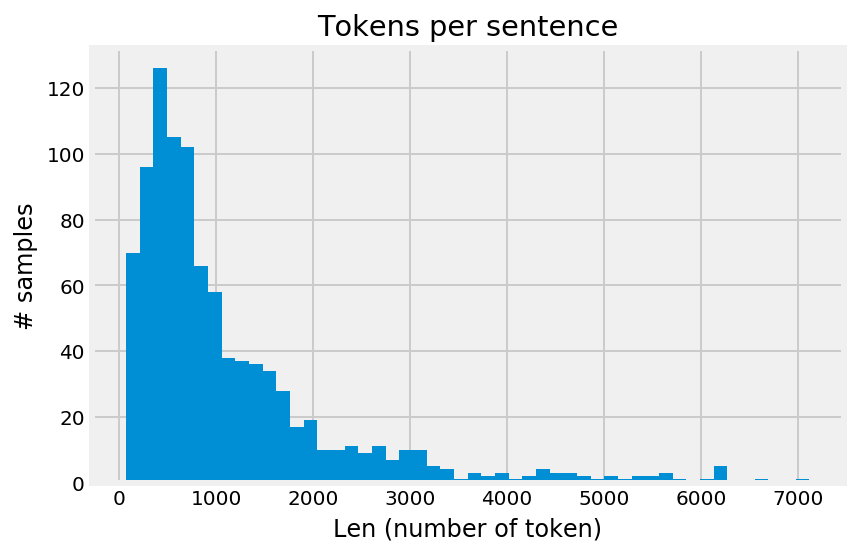

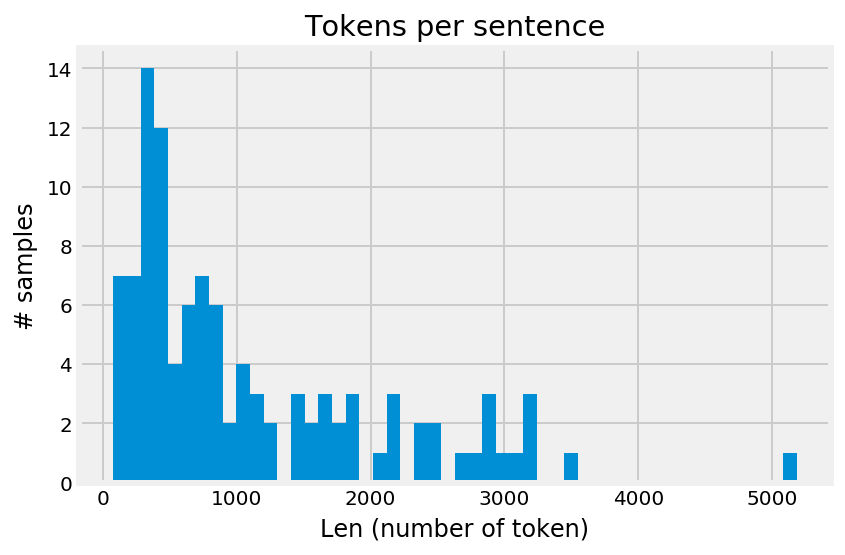

In [5]:

tok = WordPunctTokenizer()

quote = r'& quot ;'
htmlent = r'& .{2,5} ;'
combinedPattern = r'|'.join((quote, htmlent))

#Weird "isn't" -> "is n't" convertion so will revert manually this pattern 
negations_dic = {
    "is n't": "is not",
    "are n't": "are not",
    "was n't": "was not",
    "were n't": "were not",
    "have n't": "have not",
    "has n't": "has not",
    "had n't": "had not",
    "wo n't": "will not",
    "would n't": "would not",
    "do n't": "do not",
    "does n't": "does not",
    "did n't": "did not",
    "ca n't": "can not",
    "could n't": "could not",
    "should n't": "should not",
    "might n't": "might not",
    "must n't": "must not"
}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

# Custom Tokenizer
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def cleanText(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combinedPattern, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], clean)
    letters_only = re.sub("[^a-zA-Z0-9]", " ", neg_handled)
    lower_case = letters_only.lower()
    punct_handled =  re_tok.sub(r' \1 ', lower_case)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(punct_handled)
    return (" ".join(words)).strip()

demo = "& quot ; The Breakfast Club & quot ; Entertaining it is n't . `` El Dorado '' has 12 values"
print(cleanText(demo))



X_train = [ cleanText(text) for text in X_train ]
X_dev   = [ cleanText(text) for text in X_dev   ]
#display(X_train)

trainDf = pd.DataFrame({'text': X_train , 'target': y_train })
valDf   = pd.DataFrame({'text': X_dev   , 'target': y_dev   })

with pd.option_context('display.max_colwidth', 150 ):
    print('TRAIN')
    display( trainDf.head() )
    display( trainDf.target.value_counts(normalize=True) )
    print('VALIDATION')
    display( valDf.head() )
    display( valDf.target.value_counts(normalize=True) )


# Plot sentence by lenght
plt.hist([len(cleanText(s)) for s in trainDf['text'].values], bins=50)
plt.title('Tokens per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

# Plot sentence by lenght
plt.hist([len(cleanText(s)) for s in valDf['text'].values], bins=50)
plt.title('Tokens per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

### Part 2: Preparing some visualizations

In [6]:
countVectorizer = CountVectorizer()
countVectorizer.fit(trainDf.text)

print( 'Complete space of features has {:d} length'.format( 
        len( countVectorizer.get_feature_names() ) 
    )
)

Complete space of features has 16108 length


In [7]:
neg_doc_matrix = countVectorizer.transform(trainDf[trainDf.target == 0].text)
pos_doc_matrix = countVectorizer.transform(trainDf[trainDf.target == 1].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=countVectorizer.get_feature_names()).transpose()

term_freq_df.rename(
    columns={
        0: 'negative',
        1: 'positive'
    }, 
    inplace = True
)

#term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']

term_freq_df[1005:1015]

,negative,positive,total
arguably,0,2,2
argue,1,1,2
arguing,1,0,1
argument,0,1,1
arguments,0,3,3
argyle,0,1,1
arise,0,1,1
arising,0,1,1
aristocracy,0,1,1
aristrocracy,0,1,1


#### Acaso no parece la *Ley de Zipf*?

In [8]:
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
the,4974,6808,11782
and,2200,3561,5761
of,2062,2949,5011
to,2000,2640,4640
is,1688,2347,4035
it,1516,1740,3256
in,1197,1885,3082
this,1371,1453,2824
that,1125,1335,2460
not,1128,949,2077


Text(0.5,1,'Top 150 tokens in movie review')

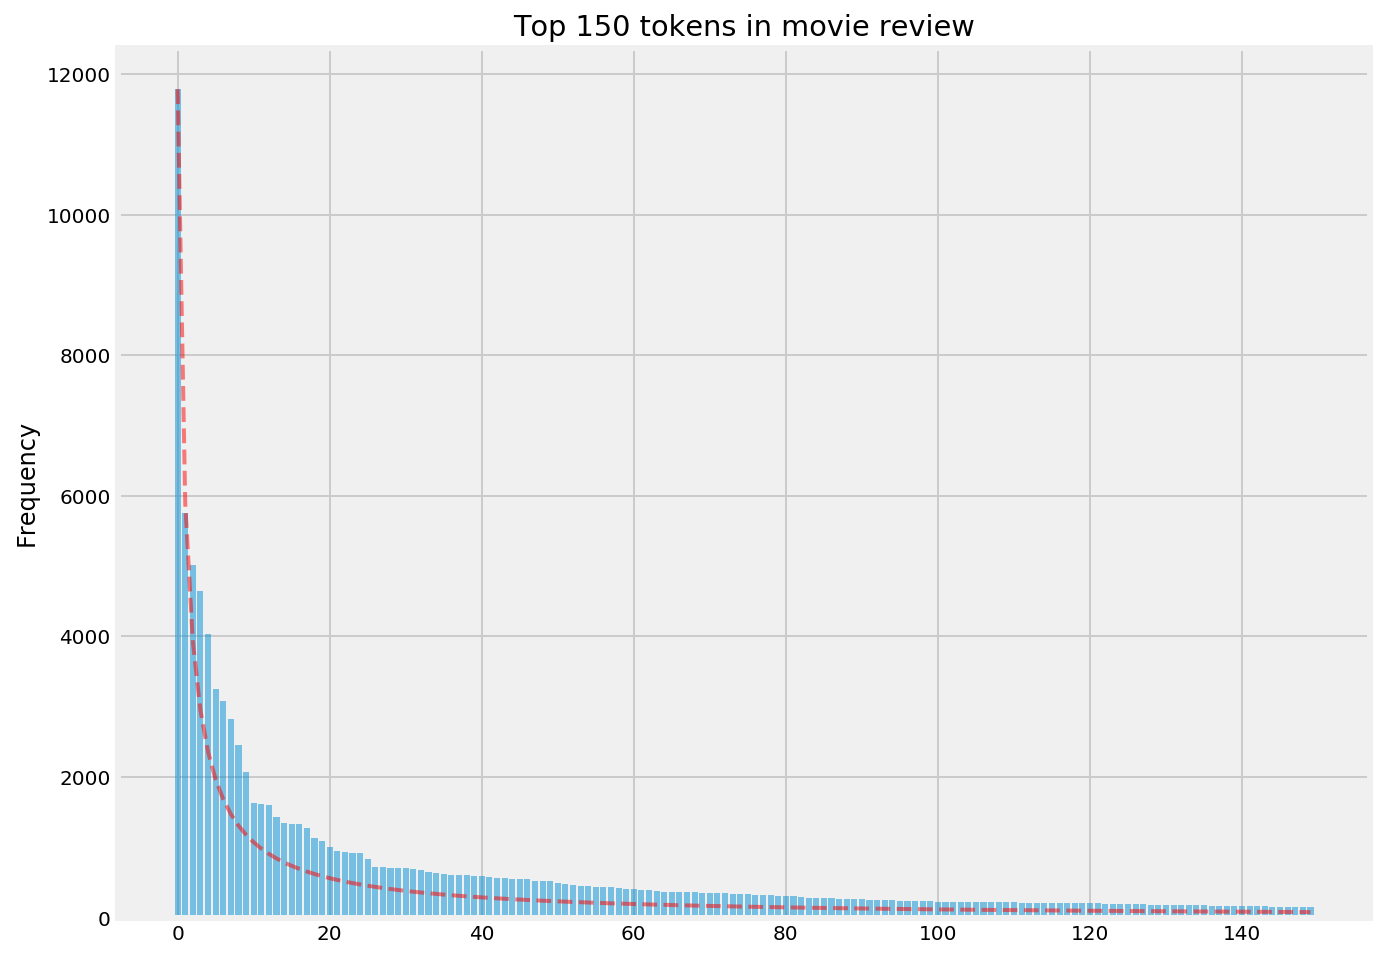

In [9]:
y_pos = np.arange(150)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:150], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 150 tokens in movie review')

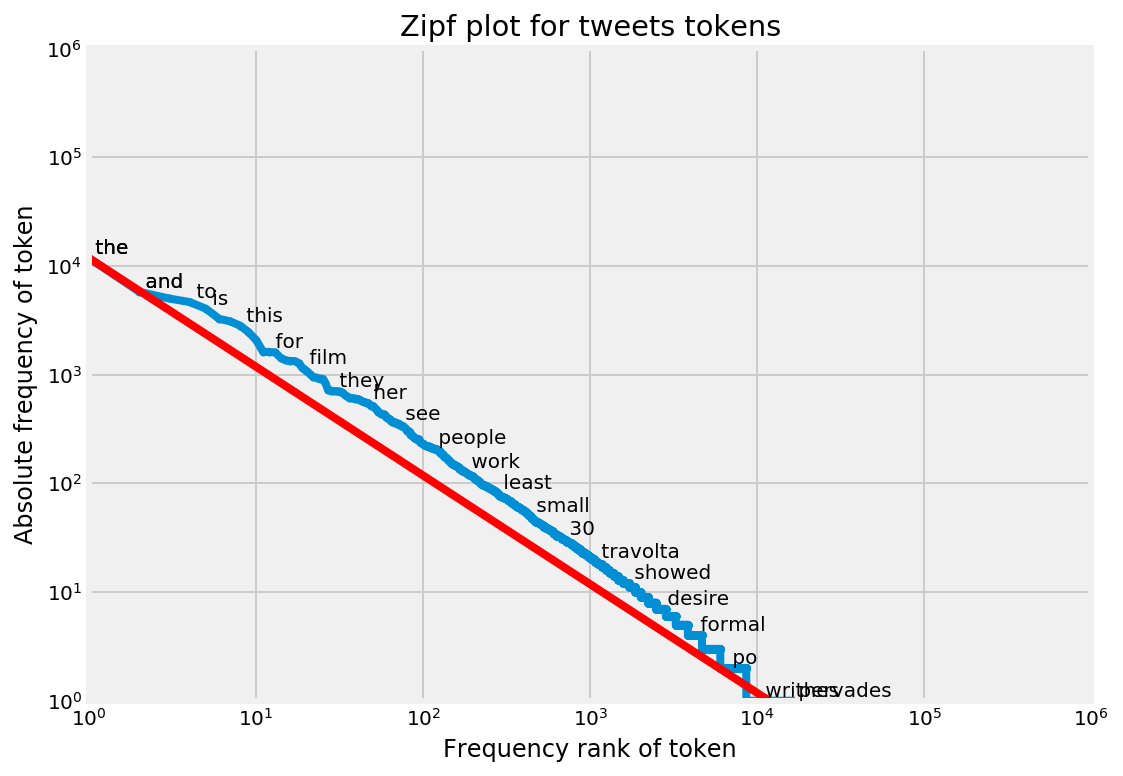

In [10]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for tweets tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

#### Visualizing features with stops words ( for negatives and positives reviews )

In [11]:
countVectorizer = CountVectorizer(stop_words='english',max_features=10000)
countVectorizer.fit(trainDf.text)

print( 'Complete space of features has {:d} length'.format( 
        len( countVectorizer.get_feature_names() ) 
    )
)

Complete space of features has 10000 length


In [12]:
neg_doc_matrix = countVectorizer.transform(trainDf[trainDf.target == 0].text)
pos_doc_matrix = countVectorizer.transform(trainDf[trainDf.target == 1].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df2 = pd.DataFrame([neg,pos],columns=countVectorizer.get_feature_names()).transpose()

term_freq_df2.rename(
    columns={
        0: 'negative',
        1: 'positive'
    }, 
    inplace = True
)

term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive']
term_freq_df2.sort_values(by='total', ascending=False).iloc[:10]


,negative,positive,total
movie,694,656,1350
film,389,749,1138
dvd,387,294,681
like,295,311,606
just,272,293,565
good,212,256,468
time,166,279,445
great,117,284,401
really,154,213,367
does,171,183,354


#### Let's see what are the top 50 words in negative reviews on a bar chart.

Text(0.5,1,'Top 50 tokens in reviews')

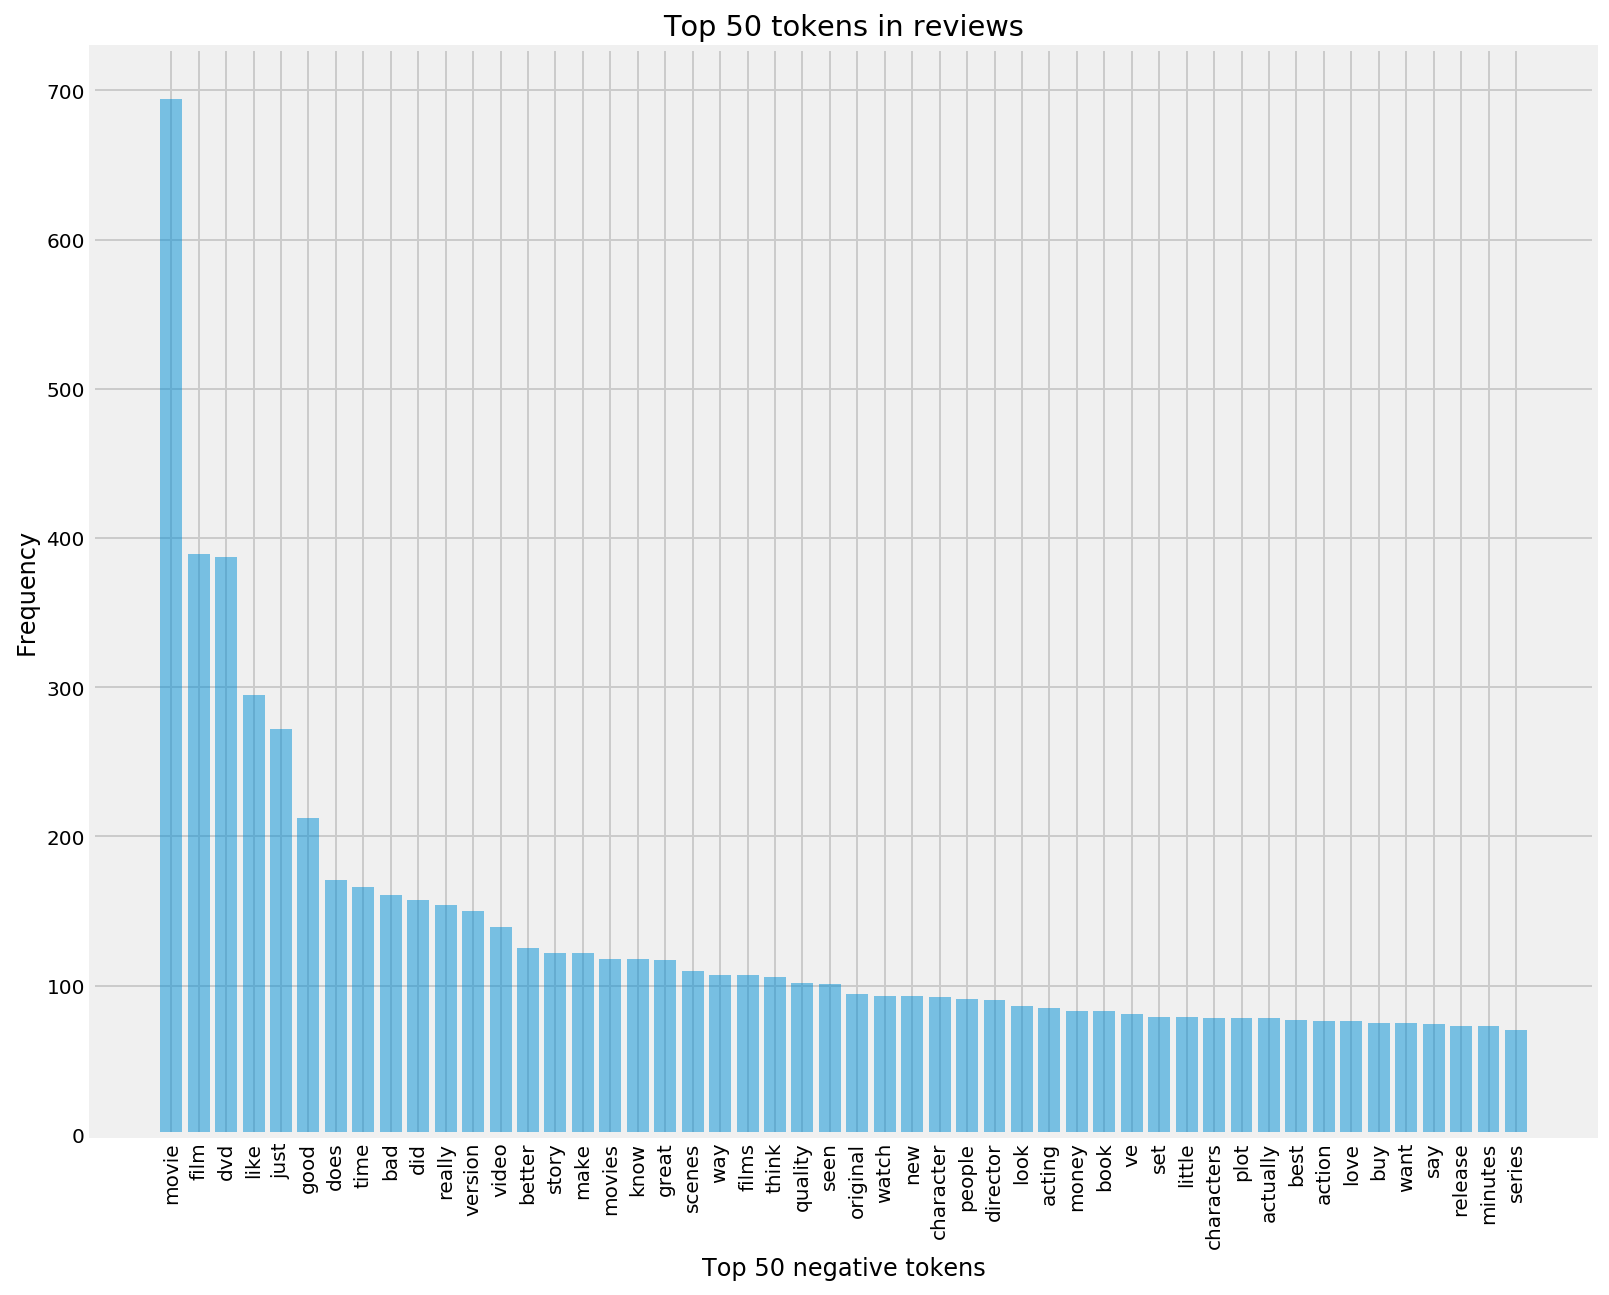

In [13]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in reviews')

#### And what about the top 50 words in positive reviews on a bar chart.

Text(0.5,1,'Top 50 tokens in positive reviews')

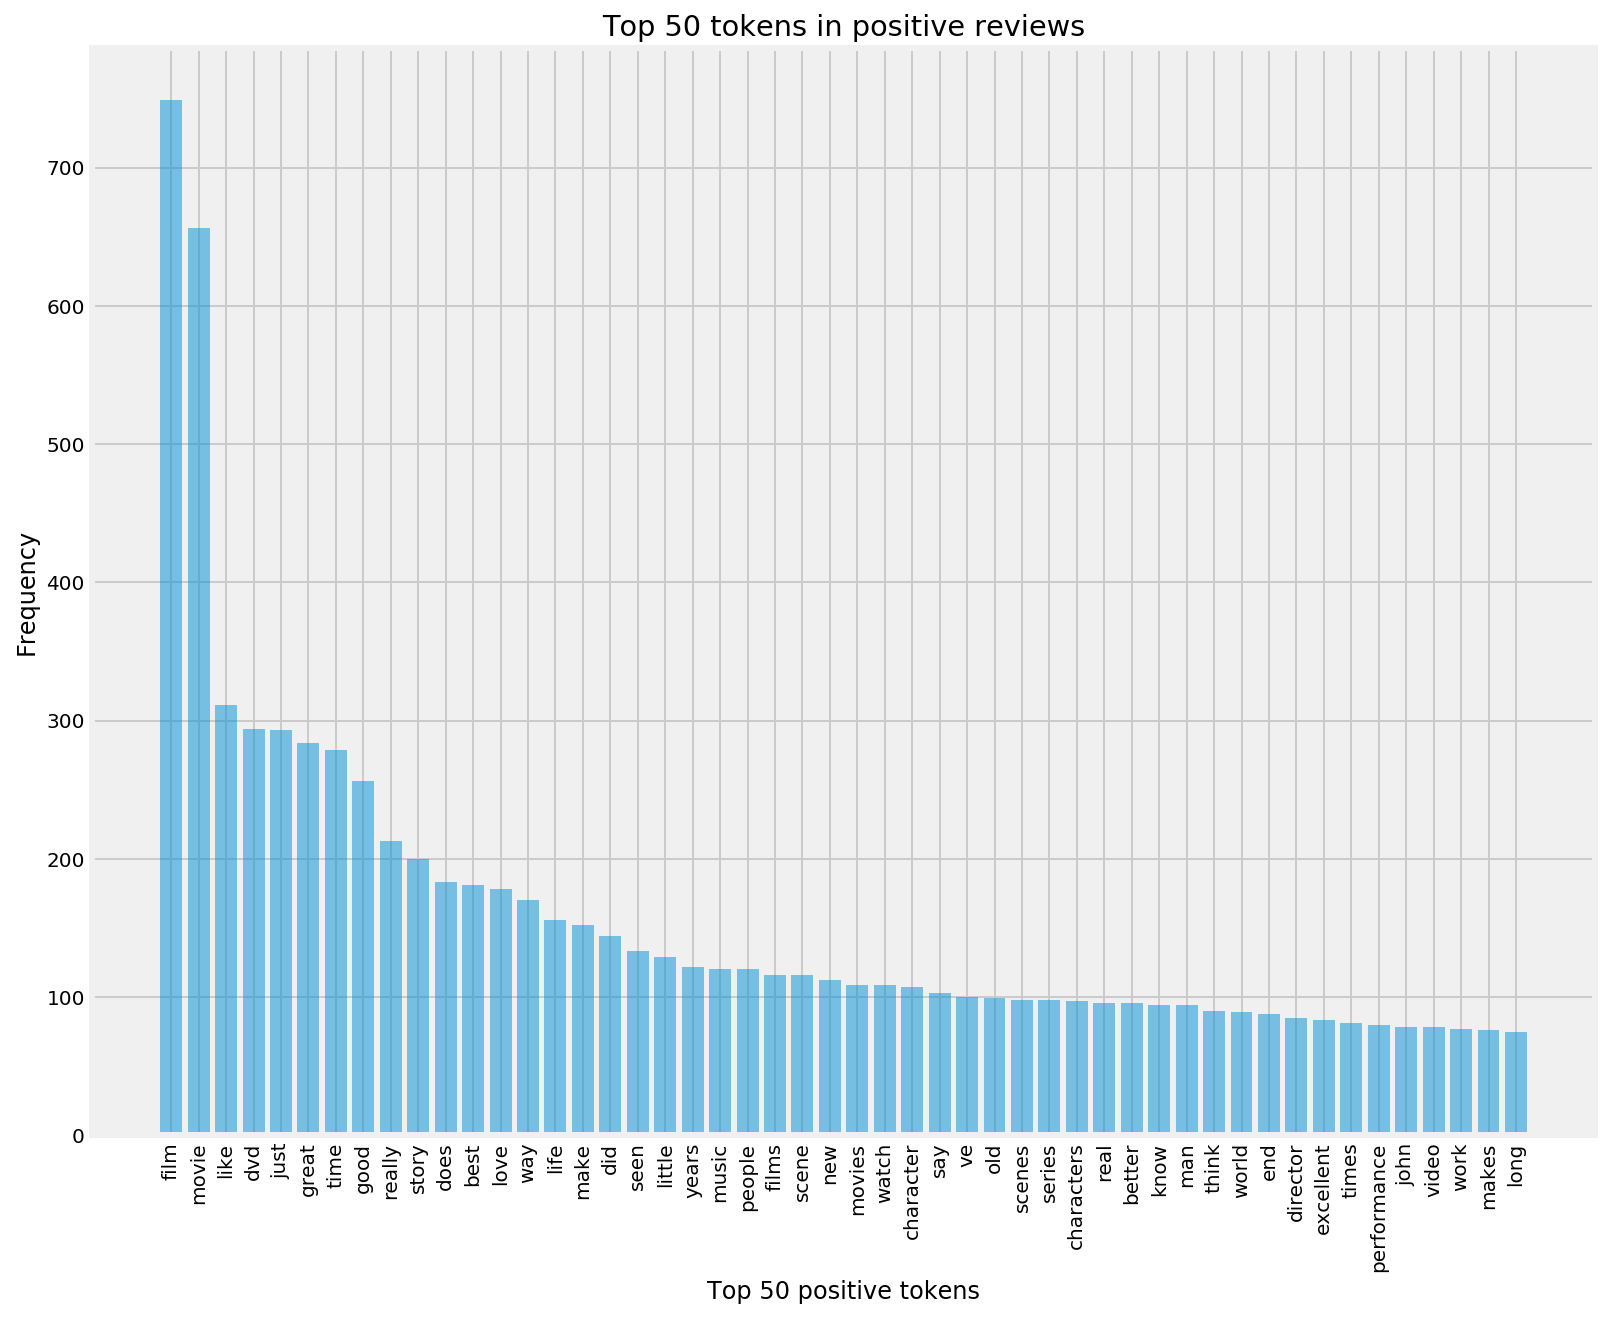

In [14]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive reviews')

Neutral words like "movie", "film" even "dvd", are quite high up in both ranks, so probably does not feed with 
so much information

What if we plot, negative frequency of a word on X-axis, and positive frequency on Y-axis? 

Text(0.5,1,'Negative Frequency vs Positive Frequency')

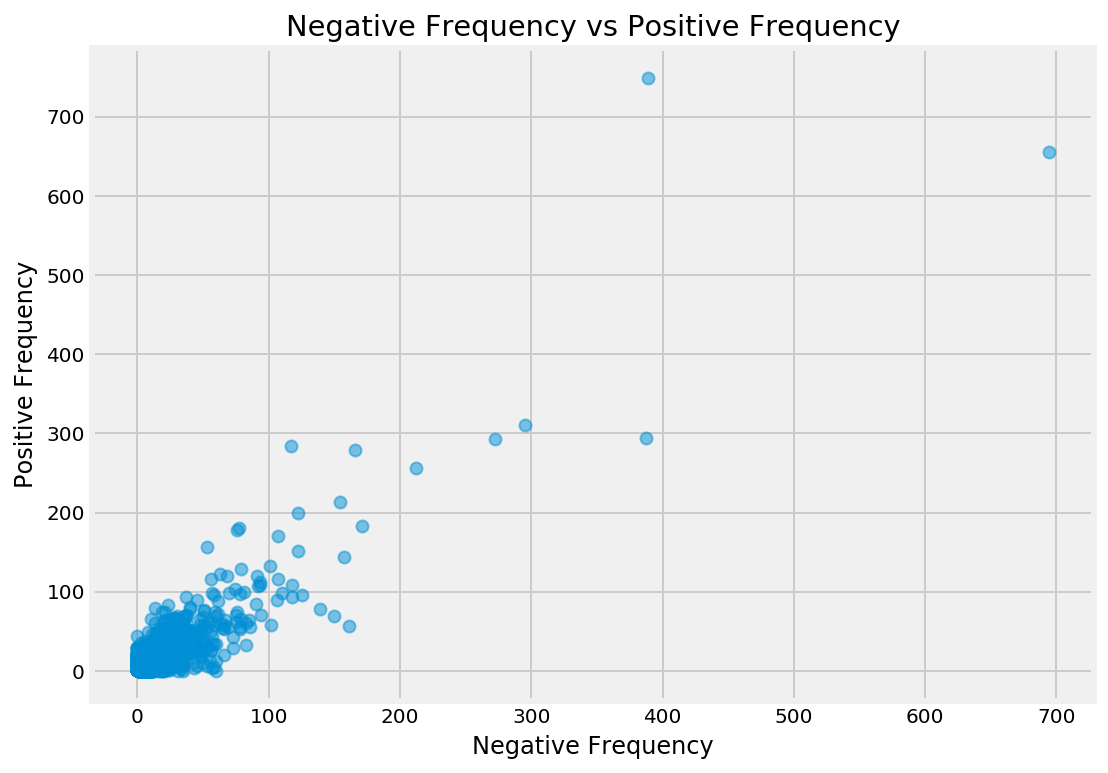

In [15]:

plt.figure(figsize=(8,6))
ax = sns.regplot(x="negative", y="positive",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

In [16]:
term_freq_df2['pos_rate'] = term_freq_df2['positive'] * 1./term_freq_df2['total']
term_freq_df2.sort_values(by='pos_rate', ascending=False).iloc[:10]

,negative,positive,total,pos_rate
00,0,2,2,1.0
principal,0,2,2,1.0
princess,0,5,5,1.0
primitivism,0,1,1,1.0
primal,0,1,1,1.0
pride,0,1,1,1.0
prices,0,1,1,1.0
prevention,0,3,3,1.0
pretentious,0,1,1,1.0
pretension,0,1,1,1.0


In this case words with high positive ratios have 0 or very low frecuency in negative reviews, but with that low frecuency cannot be considered as indicator of a positive review

In [17]:
term_freq_df2['pos_freq_pct'] = term_freq_df2['positive'] * 1./term_freq_df2['positive'].sum()
term_freq_df2.sort_values(by='pos_freq_pct', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct
film,389,749,1138,0.658172,0.014997
movie,694,656,1350,0.485926,0.013135
like,295,311,606,0.513201,0.006227
dvd,387,294,681,0.431718,0.005887
just,272,293,565,0.518584,0.005867
great,117,284,401,0.708229,0.005686
time,166,279,445,0.626966,0.005586
good,212,256,468,0.547009,0.005126
really,154,213,367,0.580381,0.004265
story,122,200,322,0.621118,0.004005


But since *pos_freq_pct* is just the frequency scaled over the total sum of the frequency, the rank of pos_freq_pct is exactly same as just the positive frequency.

In [18]:
from scipy.stats import hmean

term_freq_df2['pos_hmean'] = term_freq_df2.apply(
    lambda x: (hmean([x['pos_rate'], x['pos_freq_pct']])
               if x['pos_rate'] > 0 and x['pos_freq_pct'] > 0 else 0), 
    axis=1
)                                                        
term_freq_df2.sort_values(by='pos_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean
film,389,749,1138,0.658172,0.014997,0.029326
movie,694,656,1350,0.485926,0.013135,0.025579
like,295,311,606,0.513201,0.006227,0.012305
dvd,387,294,681,0.431718,0.005887,0.011615
just,272,293,565,0.518584,0.005867,0.011602
great,117,284,401,0.708229,0.005686,0.011282
time,166,279,445,0.626966,0.005586,0.011074
good,212,256,468,0.547009,0.005126,0.010157
really,154,213,367,0.580381,0.004265,0.008468
story,122,200,322,0.621118,0.004005,0.007958


In [19]:
from scipy.stats import norm
def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

term_freq_df2['pos_rate_normcdf'] = normcdf(term_freq_df2['pos_rate'])
term_freq_df2['pos_freq_pct_normcdf'] = normcdf(term_freq_df2['pos_freq_pct'])
term_freq_df2['pos_normcdf_hmean'] = hmean([term_freq_df2['pos_rate_normcdf'], term_freq_df2['pos_freq_pct_normcdf']])
term_freq_df2.sort_values(by='pos_normcdf_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean
65533,0,44,44,1.000000,0.000881,0.001760,0.858937,0.992162,0.920755
ritchie,0,30,30,1.000000,0.000601,0.001201,0.858937,0.939319,0.897331
eastwood,0,29,29,1.000000,0.000581,0.001161,0.858937,0.931510,0.893753
torino,0,29,29,1.000000,0.000581,0.001161,0.858937,0.931510,0.893753
gran,0,29,29,1.000000,0.000581,0.001161,0.858937,0.931510,0.893753
local,1,29,30,0.966667,0.000581,0.001161,0.837596,0.931510,0.882060
caine,0,26,26,1.000000,0.000521,0.001041,0.858937,0.903420,0.880617
strong,3,35,38,0.921053,0.000701,0.001401,0.805160,0.968474,0.879298
fred,0,25,25,1.000000,0.000501,0.001001,0.858937,0.892390,0.875344
brilliant,3,32,35,0.914286,0.000641,0.001281,0.800033,0.952834,0.869774


Same for negative values

In [20]:
term_freq_df2['neg_rate'] = term_freq_df2['negative'] * 1./term_freq_df2['total']
term_freq_df2['neg_freq_pct'] = term_freq_df2['negative'] * 1./term_freq_df2['negative'].sum()
term_freq_df2['neg_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']])
                                                                   if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0 
                                                                   else 0), axis=1)                                                        
term_freq_df2['neg_rate_normcdf'] = normcdf(term_freq_df2['neg_rate'])
term_freq_df2['neg_freq_pct_normcdf'] = normcdf(term_freq_df2['neg_freq_pct'])
term_freq_df2['neg_normcdf_hmean'] = hmean([term_freq_df2['neg_rate_normcdf'], term_freq_df2['neg_freq_pct_normcdf']])
term_freq_df2.sort_values(by='neg_normcdf_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean,neg_rate,neg_freq_pct,neg_hmean,neg_rate_normcdf,neg_freq_pct_normcdf,neg_normcdf_hmean
boll,60,0,60,0.000000,0.00000,0.00000,0.049239,0.378511,0.087142,1.000000,0.001630,0.003255,0.950761,0.999984,0.974751
bloodrayne,35,0,35,0.000000,0.00000,0.00000,0.049239,0.378511,0.087142,1.000000,0.000951,0.001900,0.950761,0.989530,0.969758
uwe,31,0,31,0.000000,0.00000,0.00000,0.049239,0.378511,0.087142,1.000000,0.000842,0.001683,0.950761,0.978004,0.964190
worst,57,4,61,0.065574,0.00008,0.00016,0.070321,0.475442,0.122520,0.934426,0.001548,0.003092,0.929679,0.999958,0.963539
game,58,5,63,0.079365,0.00010,0.00020,0.075532,0.500141,0.131243,0.920635,0.001576,0.003146,0.924468,0.999969,0.960737
slater,34,2,36,0.055556,0.00004,0.00008,0.066712,0.426421,0.115375,0.944444,0.000924,0.001846,0.933288,0.987303,0.959536
terrible,43,4,47,0.085106,0.00008,0.00016,0.077786,0.475442,0.133698,0.914894,0.001168,0.002333,0.922214,0.998128,0.958670
waste,53,6,59,0.101695,0.00012,0.00024,0.084586,0.524839,0.145691,0.898305,0.001440,0.002875,0.915414,0.999862,0.955776
horrible,45,6,51,0.117647,0.00012,0.00024,0.091536,0.524839,0.155884,0.882353,0.001222,0.002442,0.908464,0.998842,0.951512
vampire,25,1,26,0.038462,0.00002,0.00004,0.060888,0.402282,0.105767,0.961538,0.000679,0.001357,0.939112,0.942001,0.940554


Text(0.5,1,'neg_normcdf_hmean vs pos_normcdf_hmean')

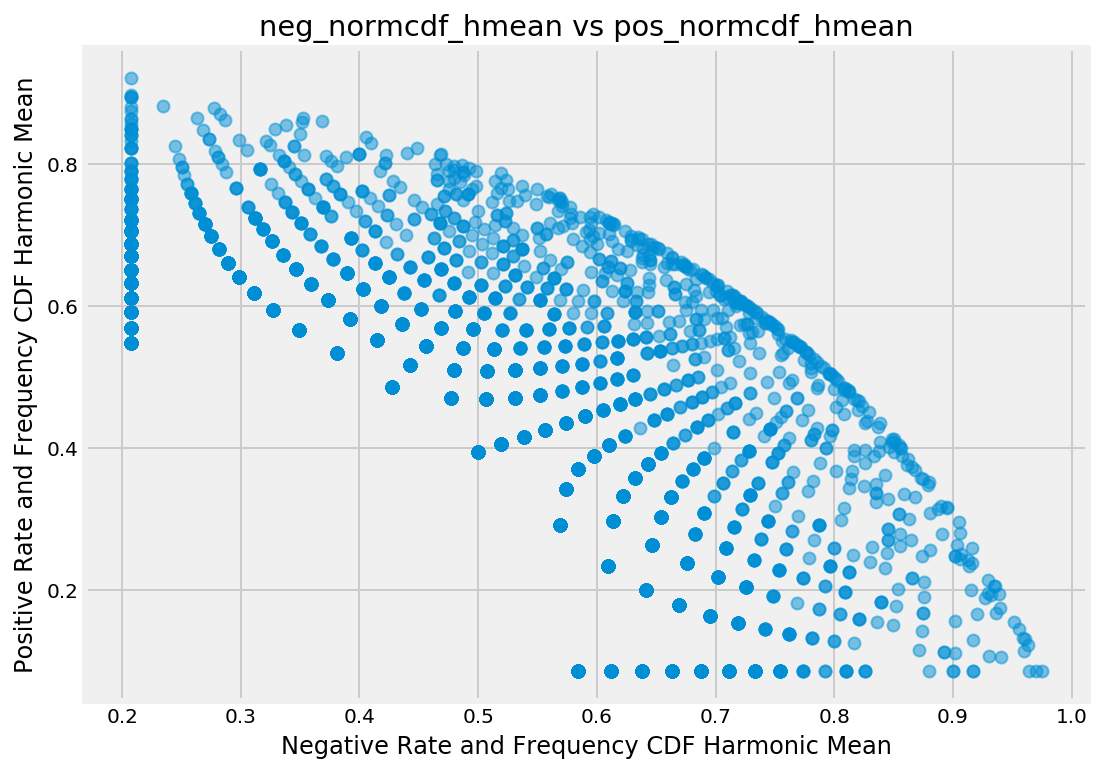

In [21]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_normcdf_hmean", y="pos_normcdf_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency CDF Harmonic Mean')
plt.xlabel('Negative Rate and Frequency CDF Harmonic Mean')
plt.title('neg_normcdf_hmean vs pos_normcdf_hmean')

In [22]:
#from bokeh.plotting import figure
#from bokeh.io import output_notebook, show
#from bokeh.models import LinearColorMapper
#output_notebook()
#color_mapper = LinearColorMapper(palette='Inferno256', low=min(term_freq_df2.pos_normcdf_hmean), high=max(term_freq_df2.pos_normcdf_hmean))
#p = figure(x_axis_label='neg_normcdf_hmean', y_axis_label='pos_normcdf_hmean')
#p.circle('neg_normcdf_hmean','pos_normcdf_hmean',size=5,alpha=0.3,source=term_freq_df2,color={'field': 'pos_normcdf_hmean', 'transform': color_mapper})
#from bokeh.models import HoverTool
#hover = HoverTool(tooltips=[('token','@index')])
#p.add_tools(hover)
#show(p)

### Baseline

In [23]:
from utils import load_datasets_unlabeled_test
train, dev, test = load_datasets_unlabeled_test()
X_train, y_train = train
X_dev, y_dev = dev

X_train = np.reshape(X_train, (-1, 1))
X_dev = np.reshape(X_dev, (-1, 1))

print( type(X_train) )
print( X_train.shape )

<class 'numpy.ndarray'>
(963, 1)


null accuracy: 50.47%
accuracy score: 88.79%
model is 38.32% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                  49                   5
positive                   7                  46
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

   negative       0.88      0.91      0.89        54
   positive       0.90      0.87      0.88        53

avg / total       0.89      0.89      0.89       107



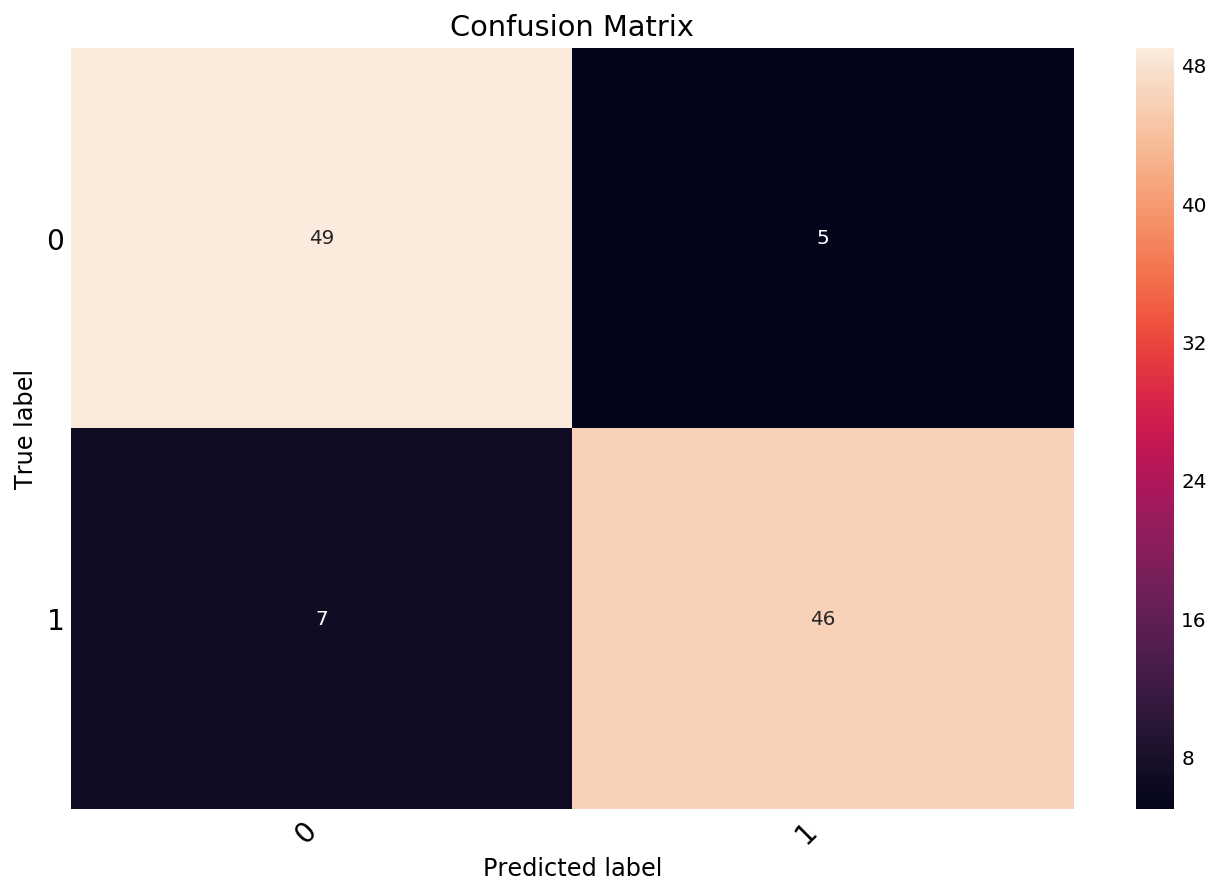

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

from utils import train_test_and_evaluate

x_train = trainDf.text
y_train = trainDf.target

x_val = valDf.text
y_val = valDf.target

pipeline = Pipeline([
    ('vect', CountVectorizer(binary=True)),
    ('clf', LogisticRegression(random_state=0)),
])
#pipeline.fit(X_train, y_train)

train_test_and_evaluate(pipeline,x_train,y_train,x_val,y_val)

null accuracy: 50.47%
accuracy score: 87.85%
model is 37.38% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                  46                   8
positive                   5                  48
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

   negative       0.90      0.85      0.88        54
   positive       0.86      0.91      0.88        53

avg / total       0.88      0.88      0.88       107



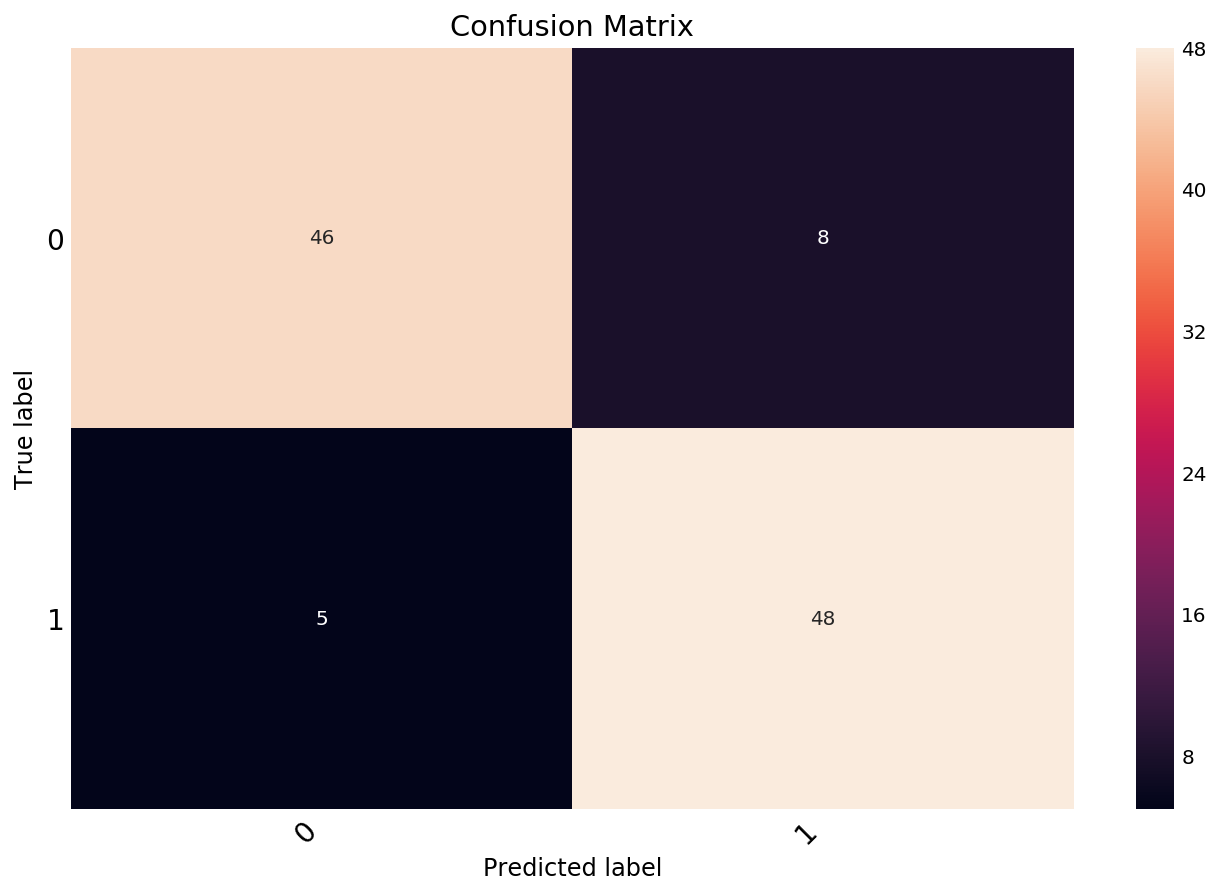

In [25]:
pipeline = Pipeline([
    ('vect', TfidfVectorizer(binary=True)),
    ('clf', LogisticRegression(random_state=0)),
])
train_test_and_evaluate(pipeline,x_train,y_train,x_val,y_val)

{'clf__C': 1, 'clf__penalty': 'l2', 'clf__tol': 0.01}

null accuracy: 50.47%
accuracy score: 80.37%
model is 29.91% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                  48                   6
positive                  15                  38
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

   negative       0.76      0.89      0.82        54
   positive       0.86      0.72      0.78        53

avg / total       0.81      0.80      0.80       107



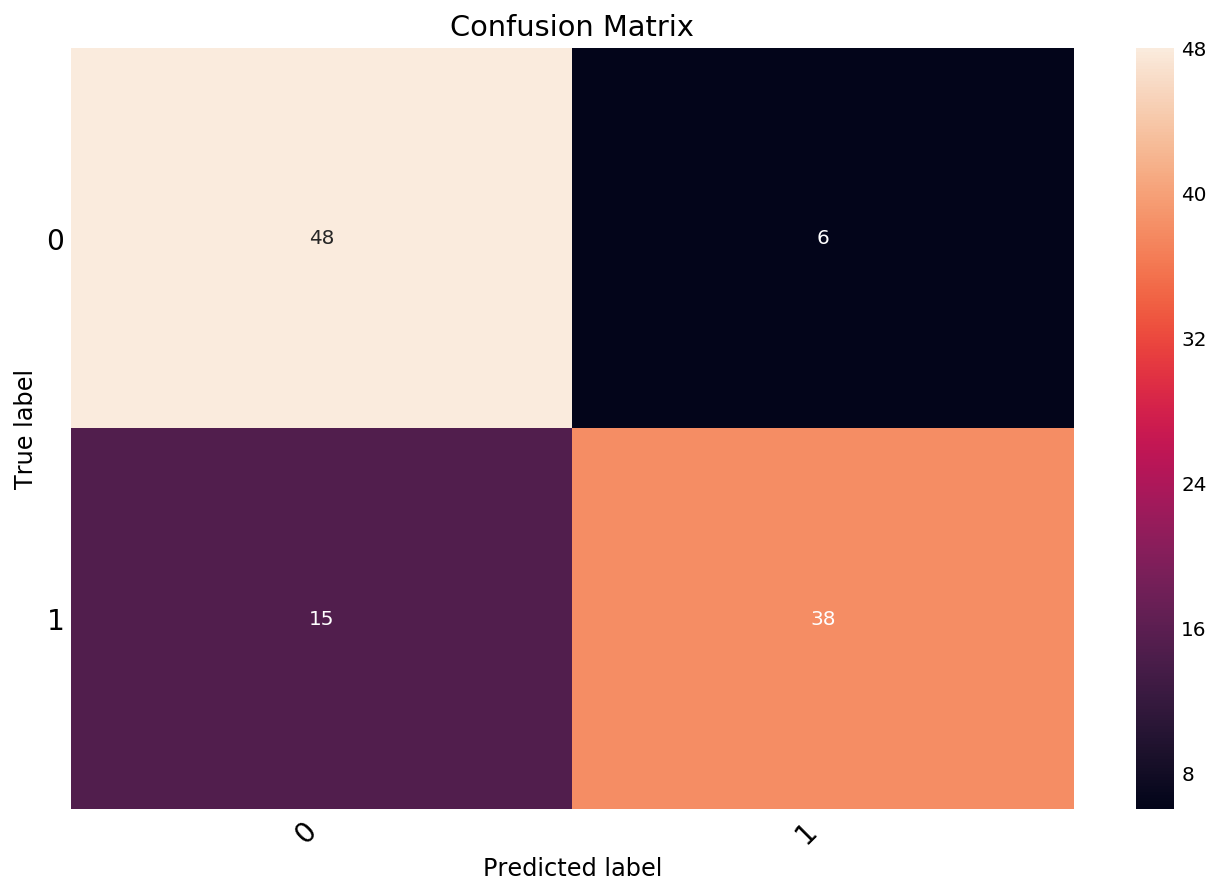

In [27]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print( "null accuracy: {0:.2f}%".format(null_accuracy*100) )
    print( "accuracy score: {0:.2f}%".format(accuracy*100)    )
    if accuracy > null_accuracy:
        print( "model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100) )
    elif accuracy == null_accuracy:
        print( "model has the same accuracy with the null accuracy" )
    else:
        print( "model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100) ) 
    print( "train and test time: {0:.2f}s".format(train_test_time) )
    print( "-"*80 )
    return accuracy, train_test_time

In [49]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel
from time import time


parameters = {
    'hidden_layer_sizes': [(256,), (512,), (32, 64, 32,)],
    'tol' : [0.01,0.001]
}


names = ["Logistic Regression","Logistic Regression CV", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LogisticRegressionCV(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
zipped_clf = list( zip(names,classifiers) )

tfidf_vec = TfidfVectorizer()
count_vec = CountVectorizer()

vectorizers = {
    'tfidf' : tfidf_vec,
    'count' : count_vec
}

def classifier_comparator(
        vectorizers = vectorizers , 
        max_features  = 17000       , 
        stop_words    = None        , 
        ngram_range   = (1, 5)      ,
        binary        = True        ,
        min_df        = 3           ,
        max_df        = 0.90        ,
        classifier    = zipped_clf ) : 
    result = []

    for vectName, vectorizer in vectorizers.items():
        
        vectorizer.set_params(
            stop_words   = stop_words  , 
            max_features = max_features  , 
            ngram_range  = ngram_range ,
            binary       = binary      ,
            min_df       = min_df      ,
            max_df       = max_df
        )
        
        for ( n , c ) in classifier:
            checker_pipeline = Pipeline([
                ( 'vectorizer', vectorizer ),
                ( 'classifier', c          )
            ])
            print( "Validation result for {} ({})".format(n,vectName) )
            print( c )
            clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train,y_train,x_val,y_val)
            result.append(( "{} ({})".format(n,vectName) ,clf_accuracy,tt_time))
    
    return result

trigram_result = classifier_comparator(
    max_features  = 170000    , 
    ngram_range = (1, 5)
)

Validation result for Logistic Regression (tfidf)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
null accuracy: 50.47%
accuracy score: 85.98%
model is 35.51% more accurate than null accuracy
train and test time: 9.45s
--------------------------------------------------------------------------------
Validation result for Logistic Regression CV (tfidf)
LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)
null accuracy: 50.47%
accuracy score: 87.85%
model is 37.38% more accurate than null accuracy
train and test time: 14.78s
-----------------------

/home/luis/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


null accuracy: 50.47%
accuracy score: 89.72%
model is 39.25% more accurate than null accuracy
train and test time: 9.30s
--------------------------------------------------------------------------------
Validation result for Passive-Aggresive (tfidf)
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=None, n_iter=None,
              n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False)


/home/luis/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


null accuracy: 50.47%
accuracy score: 87.85%
model is 37.38% more accurate than null accuracy
train and test time: 9.28s
--------------------------------------------------------------------------------
Validation result for Nearest Centroid (tfidf)
NearestCentroid(metric='euclidean', shrink_threshold=None)
null accuracy: 50.47%
accuracy score: 85.98%
model is 35.51% more accurate than null accuracy
train and test time: 9.28s
--------------------------------------------------------------------------------
Validation result for Logistic Regression (count)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
null accuracy: 50.47%
accuracy score: 89.72%
model is 39.25% more accurate than null accuracy
train and test time: 9.38s
------------------------------------------------------

/home/luis/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


null accuracy: 50.47%
accuracy score: 88.79%
model is 38.32% more accurate than null accuracy
train and test time: 9.82s
--------------------------------------------------------------------------------
Validation result for Passive-Aggresive (count)
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=None, n_iter=None,
              n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False)


/home/luis/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


null accuracy: 50.47%
accuracy score: 87.85%
model is 37.38% more accurate than null accuracy
train and test time: 9.30s
--------------------------------------------------------------------------------
Validation result for Nearest Centroid (count)
NearestCentroid(metric='euclidean', shrink_threshold=None)
null accuracy: 50.47%
accuracy score: 73.83%
model is 23.36% more accurate than null accuracy
train and test time: 9.27s
--------------------------------------------------------------------------------


In [50]:
comparison = pd.DataFrame(list(trigram_result), columns=['model','validation_accuracy','train_and_test'])
comparison.sort_values(['validation_accuracy', 'train_and_test'], ascending=[0, 1])

,model,validation_accuracy,train_and_test
8,Perceptron (tfidf),0.897196,9.302933
11,Logistic Regression (count),0.897196,9.382110
3,LinearSVC with L1-based feature selection (tfidf),0.897196,9.411251
12,Logistic Regression CV (count),0.897196,17.076915
19,Perceptron (count),0.887850,9.823517
9,Passive-Aggresive (tfidf),0.878505,9.278709
20,Passive-Aggresive (count),0.878505,9.299500
17,Ridge Classifier (count),0.878505,12.575454
1,Logistic Regression CV (tfidf),0.878505,14.777211
2,Linear SVC (tfidf),0.869159,9.382702


dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'multi_class', 'penalty', 'random_state', 'tol', 'verbose'])


{'clf__C': 2,
 'clf__multi_class': 'ovr',
 'clf__penalty': 'l2',
 'clf__tol': 0.01,
 'vect__binary': True,
 'vect__max_df': 0.9,
 'vect__max_features': 17000,
 'vect__min_df': 3,
 'vect__ngram_range': (1, 1),
 'vect__stop_words': 'english',
 'vect__strip_accents': 'unicode'}

null accuracy: 50.47%
accuracy score: 87.85%
model is 37.38% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                  52                   2
positive                  11                  42
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

   negative       0.83      0.96      0.89        54
   positive       0.95      0.79      0.87        53

avg / total       0.89      0.88      0.88       107



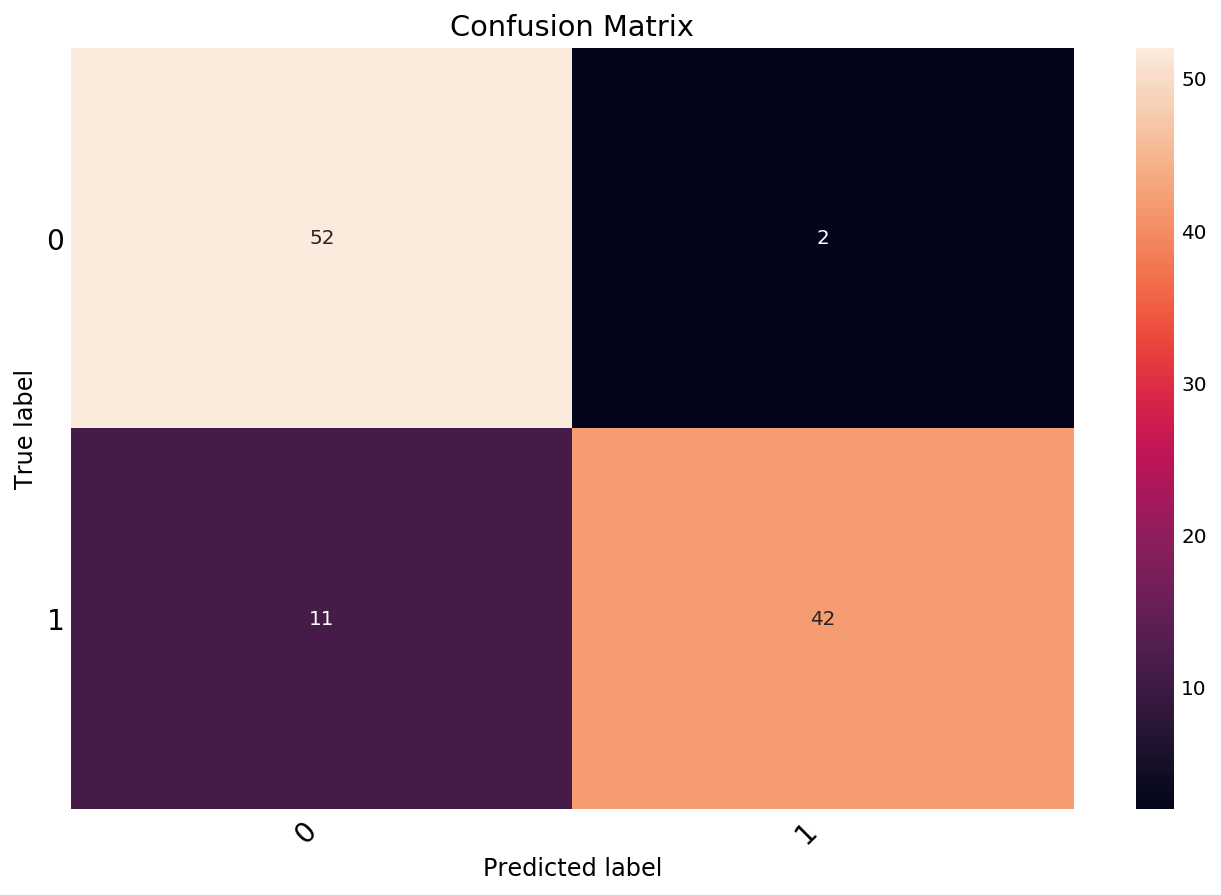

In [43]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

# Define 10 fold cross-validation
cv = KFold(n_splits=10)

logisticv_params = {
    'vect__strip_accents' : [ 'unicode'],
    'vect__ngram_range'   : [ (1, 1), (1, 3), (1, 5)],
    'vect__max_features'  : [ 17000 ]       , 
    'vect__stop_words'    : [ 'english' ]       , 
    'vect__binary'        : [ True ]        ,
    'vect__min_df'        : [ 3    ]        ,
    'vect__max_df'        : [ 0.90  ]      ,
    'clf__tol'            : [ 1e-2     ],
    'clf__C'              : [ 2        ],
    'clf__multi_class'    : [ 'ovr'    ], 
    'clf__penalty'        : [ 'l2'     ]
}

estimator = LogisticRegressionCV()

pipeline = Pipeline([
  ( 'vect' , CountVectorizer() ) , 
  ( 'feat' , SelectFromModel(LinearSVC(penalty="l1", dual=False)) ),
  ( 'clf'  , estimator )
])

print(estimator.get_params().keys())

# Define the model & input the hyperparameter dictionary objects into the GridSearchCV function
svm_model = GridSearchCV(pipeline, param_grid=logisticv_params, scoring='roc_auc', cv=cv)

# Test the SVC estimator with its grid of hyperparamters on the training set
svm_model.fit(x_train,y_train)

display( svm_model.best_params_ )

train_test_and_evaluate(pipeline,x_train,y_train,x_val,y_val)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

# Define 10 fold cross-validation
cv = KFold(n_splits=10)

linearscv_params = {
    'vect__strip_accents' : [ 'unicode'],
    'vect__ngram_range'   : [ (1, 1), (1, 3), (1, 5)],
    'vect__max_features'  : [ 17000 ]       , 
    'vect__stop_words'    : [ 'english' ]       , 
    'vect__binary'        : [ True ]        ,
    'vect__min_df'        : [ 3    ]        ,
    'vect__max_df'        : [ 0.90  ]      ,
    'clf__tol'            : [ 1e-2     ],
    'clf__C'              : [ 2        ],
    'clf__multi_class'    : [ 'ovr'    ], 
    'clf__penalty'        : [ 'l2'     ]
}

estimator = LinearSVC() # {'clf__C': 2, 'clf__multi_class': 'ovr', 'clf__penalty': 'l2','clf__tol': 0.01}

pipeline = Pipeline([
  ( 'vect' , TfidfVectorizer() ) , 
  ( 'feat' , SelectFromModel(LinearSVC(penalty="l1", dual=False)) ),
  ( 'clf'  , estimator )
])

print(estimator.get_params().keys())

# Define the model & input the hyperparameter dictionary objects into the GridSearchCV function
svm_model = GridSearchCV(pipeline, param_grid=linearscv_params, scoring='roc_auc', cv=cv)

# Test the SVC estimator with its grid of hyperparamters on the training set
svm_model.fit(x_train,y_train)

display( svm_model.best_params_ )

train_test_and_evaluate(pipeline,x_train,y_train,x_val,y_val)

In [52]:
estimator = LogisticRegressionCV()
print(estimator.get_params().keys())
np.power(10.0, np.arange(-10, 10))

dict_keys(['Cs', 'class_weight', 'cv', 'dual', 'fit_intercept', 'intercept_scaling', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'refit', 'scoring', 'solver', 'tol', 'verbose'])


array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09])